In [1]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import the jsonified transactions into a dataframe

In [3]:
path = '/Users/Sarah/galvanize/dsi-capstone/data/jsons/2015'
all_files = glob.glob(os.path.join(path, "*.json"))

In [ ]:
path = '/Users/Sarah/galvanize/dsi-capstone/data/jsons/2018noaccount/'
all_files.append(glob.glob(os.path.join(path, "*.json")))

In [ ]:
all_files

In [4]:
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [ ]:
for types in df.type.unique():
    print(types)    

In [5]:
df=df[df['type']=='Checkout']

In [6]:
df.drop(columns='type',inplace=True)

In [7]:
print("terminals (registers):",df.term.unique())

terminals (registers): [13  9 12  7  3  8 10  5  2  1  4 11  6]


Drop transactions from register other than 1-9. Register 10 is the customer service desk returns register. Register 11 is the worker self checkout register.

In [8]:
df=df[df['term']<10]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837946 entries, 14 to 2875
Data columns (total 10 columns):
account    837946 non-null object
date       837946 non-null object
gross+     837946 non-null float64
gross-     837946 non-null float64
items      837946 non-null object
net        837946 non-null float64
oper       837946 non-null int64
term       837946 non-null int64
time       837946 non-null object
trans      837946 non-null int64
dtypes: float64(3), int64(3), object(4)
memory usage: 70.3+ MB


In [ ]:
df.isna().sum()

In [ ]:
df['account'].fillna([],inplace=True)

In [ ]:
df.info()

In [ ]:
df = pd.concat([df,df2], axis=0, ignore_index=True)

In [10]:
df['date']=pd.to_datetime(df['date'],yearfirst=True)

In [11]:
df['day_of_week']=df['date'].dt.day_name()
df['month']=df['date'].dt.month

In [12]:
pickle.dump(df,open('./data/pickles/df2015.p','wb'))

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [ ]:
df = pickle.load(open('./data/pickles/df2015.p','rb'))

In [ ]:
df.info()

In [ ]:
df.drop(columns='type',inplace=True)

In [100]:
def get_items(df,most_common=10,least_common=5):
    df['total_of_items'] = 0
    stoppers = ['BAG CREDIT','SF Bag Charge','Gift Card Reload','8 OZ BIO TUB t3', '16OZ BIO TUB t4',
                 '32OZ BIO TUB t5','8 OZ PLSTC TUB t3','16 OZ PLSTC TUB t4','BOTTLE DEPOSIT','6PACK BEER SMALL C','PAID IN','Gift Card Sale',
                'PACKAGED FOOD', ]  
    '''build a dictionary where the keys are the words
    in the dataframe items column'''
    stopwords =[]
    items=[]
    item_dict = defaultdict(int)
    basket_counts=[]
    
    for basket in df['items']:
        basket_counts.append(len(basket))
        for item in basket:
            
            items.append(item[1])
            item_dict[item[1]] += 1
    
    items_set=set(items)

    '''add the most common words to the stopwords list'''
    stopwords=list([i[0] for i in Counter(item_dict).most_common(most_common)])
    
    '''if topics_list exist, add these to stopwords to reveal next layer down'''
    if topics_list:
        for topics in topics_list:
            for i in topics:
                stopwords.append(i)
            
    '''add predetermined stoppers to stopwords list'''
    for s in stoppers:
        stopwords.append(s)
        
    '''add items containing "CRV" to the stopwords list'''
    for item in items_set:
        if "crv" in item.lower():
            stopwords.append(item)
    
    '''add the least common words to the stopwords list'''
    for key,value in item_dict.items():
        if value < least_common:
            stopwords.append(key)
    print(type(stopwords))
    #print(stopwords)
    stopwords_set = set(stopwords)
    
    '''iterate through the baskets and add items to items_set
    if not in stopwords (too common or too uncommon)'''
    for stops in stopwords_set:
        items_set.remove(stops)
  

    return items_set,stopwords_set, item_dict, basket_counts

items_set,stopwords,item_dict, basket_counts = get_items(df,most_common=3,least_common=15)

<class 'list'>
['BAG CREDIT', 'SMALL COOLER CRV', 'SF Bag Charge', 'PEPPERS, RED BELL', 'CARROTS, LOOSE', 'SQUASH, ZUCCHINI', 'CELERY', 'KALE, DINO', 'CUCUMBERS', 'BROCCOLI, LOOSE', 'SPINACH, LOOSE', 'LETTUCE, SALAD MIX', 'BEANS, GREEN', 'BANANAS', '1lb STRAWBERRY', 'APPLES, GALA', 'BAGEL', 'APPLES, PINK LADY', 'BLUEBERRIES', 'PEACH', 'ORANGES, NAVEL', 'NECTARINE', 'SPINACH, LOOSE', 'AVOCADOS, HASS', '1lb STRAWBERRY', 'TOMATO, MIX HEIRLO', 'BLUEBERRIES', 'LIMES', 'PEACH', 'TOMATOES, CLUSTER', 'NECTARINE', 'TOMATO, DRY FARM', 'LETTUCE, SALAD MIX', 'APPLES, FUJI', 'ORANGES, NAVEL', 'PEAR, BOSC', 'PEAR, BARTLETT', 'CARROTS, BUNCH', 'LETTUCE, SALAD MIX', 'GRAPEFRUIT', 'SATSUMA MANDARIN', 'ORANGES, VALENCIA', 'BAGEL', 'ONIONS, YELLOW', 'POTATOES, YELLOW', 'POTATOES, GARNET', 'CARROTS, BUNCH', 'MUSHROOM, CRIMINI', 'POTATOES, RUSSET', 'LEEKS', 'PEPPER, CHILI', 'POTATOES, RED', 'CABBAGE, GREEN', 'REFRIGERATED', 'BAKERY', 'PRODUCE', 'BULK', '1lb STRAWBERRY', 'BATH & BODY', 'BLUEBERRIES', 'CHEES

In [102]:
Counter(item_dict).most_common(50)

[('BAG CREDIT', 660410),
 ('SMALL COOLER CRV', 170263),
 ('SF Bag Charge', 167505),
 ('BANANAS', 122079),
 ('Sr. 10% Produce', 98797),
 ('Sr. 10% Bulk', 89426),
 ('Sr. 10% Pkg Food', 84850),
 ('AVOCADOS, HASS', 82047),
 ('Sr. 10% Refrigera', 76830),
 ('CRV SMALL NO TAX', 68696),
 ('ONIONS, YELLOW', 61581),
 ('REFRIGERATED', 56568),
 ('CRV LRG SING NOTAX', 56403),
 ('Sr. 10% Bakery', 52274),
 ('BOTTLE DEPOSIT', 48887),
 ('CRV SMALL SING T', 45640),
 ('APPLES, FUJI', 44451),
 ('GARLIC, WHITE', 44337),
 ('LEMONS', 39210),
 ('Sr. 10% Cheese', 38521),
 ('Sr. 10% Vitamin TX', 36648),
 ('CRV LRG SING T', 35323),
 ('PEPPERS, RED BELL', 35228),
 ('KALE, DINO', 35064),
 ('CARROTS, LOOSE', 35019),
 ('8 OZ BIO TUB t3', 34134),
 ('Sr. 10% BB TX', 33200),
 ('1lb STRAWBERRY', 32873),
 ('PACKAGED FOOD', 32838),
 ('SQUASH, ZUCCHINI', 30692),
 ('CELERY', 29963),
 ('ONIONS, RED', 29472),
 ('BAGEL', 28305),
 ('Worker 20% PkgFood', 28143),
 ('GINGER', 28043),
 ('LETTUCE, SALAD MIX', 27701),
 ('CUCUMBERS', 

In [103]:
len(items_set)

28393

In [104]:
df['items'].sample(10)

168927    [[, L&L'S CHOC CHIP, 1.99, 17], [, ZEVIACAFF-F...
184016    [[, EPI CURRIED TOFU, 3.79, 13], [, EPI WILD R...
706944    [[, 2446 OLIVE CERIGNO, 2.7, 16], [, 8 OZ PLST...
89955     [[, GF VEGAN PIE, 16.45, 17], [, KLASSIC MUSH ...
390015    [[, 2793 CHOC NUT MIX, 6.68, 16], [, GARROTXA,...
715943    [[, CLARA RAW MILK QT, 5.29, 13], [DP, BOTTLE ...
400488    [[, MUSHROOM, CRIMINI, 3.34, 12], [, PLUOT, RE...
78912     [[, SPECTRUM ORG VINEG, 5.99, 15], [, EDEN GAR...
268686    [[, NO Sun Lecithin 10, 7.99, 1], [, EL Prosta...
315699    [[, VITAMINS, 8.46, 1], [, VITAMINS, 6.48, 1],...
Name: items, dtype: object

In [ ]:
df['item_count']=basket_counts

In [15]:
percentile = np.percentile(basket_counts, [25, 50, 75])
q1=percentile[0]
q2=percentile[1]
q3=percentile[2]

In [16]:
q1,q2,q3

(4.0, 9.0, 18.0)

In [ ]:
dfq1=df[(df['item_count']<=q1)]
dfq2=df[(df['item_count']>q1 )& (df['item_count']<=q2)]
dfq3=df[(df['item_count']>q2 )& (df['item_count']<=q3)]
dfq4=df[df['item_count']>q3]
df_avg=df[(df['item_count']>=10 )& (df['item_count']<=12)]

In [ ]:
df = df[df['item_count']>q2]

In [ ]:
df['item_count'].max()

In [ ]:
plt.scatter(dfq1['time'],dfq1['item_count'])

In [105]:
item_matrix = np.zeros((df.shape[0],len(items_set)))

In [106]:
df_items= pd.DataFrame(item_matrix,columns=items_set)

In [107]:
df.index

RangeIndex(start=0, stop=837946, step=1)

In [108]:
df=df.reset_index()

In [109]:
df.index

RangeIndex(start=0, stop=837946, step=1)

In [110]:
df.describe()

,index,gross+,gross-,net,oper,term,trans,month,total_of_items
count,837946.000000,837946.000000,837946.000000,837946.000000,837946.000000,837946.000000,837946.000000,837946.000000,837946.0
mean,418972.500000,57.963661,2.670784,55.293091,50.863132,5.674072,186.231769,6.513269,0.0
std,241894.318672,223.928030,212.752828,78.565774,28.474850,2.123342,121.724159,3.435884,0.0
min,0.000000,0.000000,0.000000,-19682.210000,1.000000,1.000000,1.000000,1.000000,0.0
25%,209486.250000,14.520000,0.000000,14.190000,25.000000,4.000000,86.000000,4.000000,0.0
50%,418972.500000,35.230000,0.000000,34.600000,53.000000,6.000000,174.000000,7.000000,0.0
75%,628458.750000,73.690000,0.000000,72.300000,73.000000,8.000000,268.000000,10.000000,0.0
max,837945.000000,90089.790000,89990.100000,25290.700000,110.000000,9.000000,705.000000,12.000000,0.0


In [111]:
df.pop('index')
print ()

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837946 entries, 0 to 837945
Data columns (total 13 columns):
account           837946 non-null object
date              837946 non-null datetime64[ns]
gross+            837946 non-null float64
gross-            837946 non-null float64
items             837946 non-null object
net               837946 non-null float64
oper              837946 non-null int64
term              837946 non-null int64
time              837946 non-null object
trans             837946 non-null int64
day_of_week       837946 non-null object
month             837946 non-null int64
total_of_items    837946 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(5), object(4)
memory usage: 83.1+ MB


In [113]:
df.iloc[:,0].index


RangeIndex(start=0, stop=837946, step=1)

In [114]:
df_items.iloc[:,0].index

RangeIndex(start=0, stop=837946, step=1)

In [115]:
col_index_dict = dict(zip(items_set, range(len(items_set))))

In [116]:
col_index_dict['BANANAS']

KeyError: 'BANANAS'

In [117]:
df.shape[0]

837946

In [118]:
matrix_dict = defaultdict(int)
for i in range(df.shape[0]):
    for item in df['items'][i]:
        #set matrix to boolean for item precence in basket:
        #if item[1] not in stopwords and item[3] != 12:
        #if item[1] not in stopwords and item[3] not in (12,16):
        if item[1] not in stopwords:
            if item[2] > 0:
                value = 1
            elif item[2] == 0:
                value = 0
            else:
                value = -1
            matrix_dict[i,col_index_dict[item[1]]] += value

In [119]:
for item in items_set:
    if item.startswith('ONION'):
        print (item)

ONIONS, WHITE
ONIONS, SPRING
ONION POWDER
ONION GRUY CHZ RAV
ONIONS, SWEET
ONION, CIPOLLINI


In [ ]:
len(matrix_dict)

In [ ]:
for key,value in matrix_dict.items():
    print (key[0])
    print (key[1])
    print (value)
    break

In [120]:
rows, cols, vals = [], [], []
for key, value in matrix_dict.items():
    rows.append(key[0])
    cols.append(key[1])
    vals.append(matrix_dict[key])
sparse_matrix = sparse.csr_matrix((vals, (rows, cols)))

In [ ]:
len(rows)

In [ ]:
import pickle

In [ ]:
sparse_matrix[4]

In [32]:
pickle.dump(sparse_matrix,open('./data/pickles/sparse_matrix2015.p','wb'))

In [33]:
pickle.dump(items_set,open('./data/pickles/items_set2015.p','wb'))

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import decomposition, datasets, model_selection, preprocessing, metrics
import src.rainbow
import os
import glob
import pickle
import time


In [ ]:
file = open("./data/pickles/sparse_matrix2015.p",'rb')
sparse_matrix = pickle.load(file)
file.close()

In [ ]:
file = open("./data/pickles/items_set2015.p",'rb')
items_set = pickle.load(file)
file.close()

In [121]:
sparse_matrix = (sparse_matrix > 0).astype(int)

In [ ]:
sum_of_zeros=sum(np.sum(sparse_matrix,axis=1)==0)
print(sum_of_zeros / sparse_matrix.shape[0],"% of zero weight baskets")

In [122]:
def fit_NMF(sparse_matrix_,n_components_,max_iter=250):
    from sklearn.decomposition import NMF
    model = NMF(n_components=n_components_,max_iter=max_iter)
    W = model.fit_transform(sparse_matrix_)
    H=model.components_
    model_iter = model.n_iter_
    return model,W,H,model_iter
model,W,H,model_iter = fit_NMF(sparse_matrix,n_components_=8,max_iter=250)

In [123]:
print('iterations:',model_iter,'W shape:',W.shape,'H shape:',H.shape)

iterations: 26 W shape: (837946, 8) H shape: (8, 28393)


In [124]:
w = np.zeros_like(W)
w[np.arange(len(W)), W.argmax(1)] = 1
topic_strength = np.sum(w,axis=0)
topic_strength = np.round(topic_strength/topic_strength.sum(),2)
for i,t in enumerate(topic_strength):
    print('topic %d srength: %f '%(i,t))

topic 0 srength: 0.680000 
topic 1 srength: 0.070000 
topic 2 srength: 0.050000 
topic 3 srength: 0.020000 
topic 4 srength: 0.020000 
topic 5 srength: 0.020000 
topic 6 srength: 0.120000 
topic 7 srength: 0.020000 


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
model = LDA(n_components=2,max_iter=10)
W = model.fit_transform(sparse_matrix)
H = model.components_
model.n_iter_

In [ ]:
rebuilt = np.dot(W,H)

In [ ]:
rebuilt.shape

In [ ]:
for topic in H:
    print (topic[:-10:-1])

In [125]:
feature_names=list(items_set).copy()
n_top_words=10
for topic in H:
    print(topic.argsort()[:-n_top_words -1:-1])
    print ([feature_names[i]for i in topic.argsort()[:-n_top_words -1:-1]])
    print()

[12198  5493  8816 15158 16960  8388 16111 20908 22364 10546]
['MUSHROOMS, SHIITAK', 'HERBS, BASIL', 'CUKE MEDIT/PERSIAN', 'GRAPES, RED', 'BEETS, RED LOOSE', 'CABBAGE, RED', 'APPLES, GRANNY SMI', 'LETTUCE, ROMAINE', 'BROCCOLI, BABY SWE', 'POTATOES, JAPANESE']

[23249 27235  2589  6452 14800 18611 15494 16411  8095  7410]
['8 OZ PLSTC TUB t3', '16OZ PLSTC TUB t4', '2448 CASTEL OLIVE', '2450 KALAMATA-PIT', '2435 BLACK OLIVE', '5495 COCONUT OIL', '24OZ PLSTC TUB t5', '2458 PITD GRN OLIV', '2572 DOLMAS', '2455 OLIVE MEDLEY']

[12915 27083 19096 21853 23572 23177 14489  6057 17316 17285]
['5290 WALNUTS', '5120 ORG ALMONDS', '5250 ORG PECAN HA', '5150 BRAZIL NUTS', '6645 SUNFLWR SEEDS', '5180 WHOLE CASHEWS', '5161 CASHEW PIECES', '6560  PUMPKIN SEED', '3295  FLAME RAISIN', '3080 MEDJOOL DATES']

[11003 16249 16960 21228  8388  2315 17598 20303  2816 15642]
['KALE, GREEN', 'COLLARDS', 'BEETS, RED LOOSE', 'BROCCOLI,  BUNCHED', 'CABBAGE, RED', 'CHARD, RED', 'DANDELION', 'CHARD, RAINBOW', 'CARRO

In [126]:
pickle.dump(sparse_matrix,open('./data/pickles/topics_list2015.p','wb'))

0.68 Topic #0:
['MUSHROOMS, SHIITAK', 'HERBS, BASIL', 'CUKE MEDIT/PERSIAN', 'GRAPES, RED', 'BEETS, RED LOOSE', 'CABBAGE, RED', 'APPLES, GRANNY SMI', 'LETTUCE, ROMAINE', 'BROCCOLI, BABY SWE', 'POTATOES, JAPANESE']


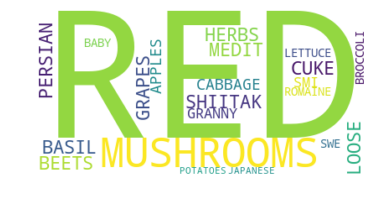

<img src="./img/2018/1554485618.topic0.png">
0.07 Topic #1:
['8 OZ PLSTC TUB t3', '16OZ PLSTC TUB t4', '2448 CASTEL OLIVE', '2450 KALAMATA-PIT', '2435 BLACK OLIVE', '5495 COCONUT OIL', '24OZ PLSTC TUB t5', '2458 PITD GRN OLIV', '2572 DOLMAS', '2455 OLIVE MEDLEY']


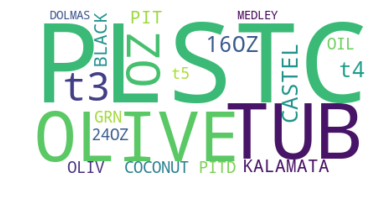

<img src="./img/2018/1554485619.topic1.png">
0.05 Topic #2:
['5290 WALNUTS', '5120 ORG ALMONDS', '5250 ORG PECAN HA', '5150 BRAZIL NUTS', '6645 SUNFLWR SEEDS', '5180 WHOLE CASHEWS', '5161 CASHEW PIECES', '6560  PUMPKIN SEED', '3295  FLAME RAISIN', '3080 MEDJOOL DATES']


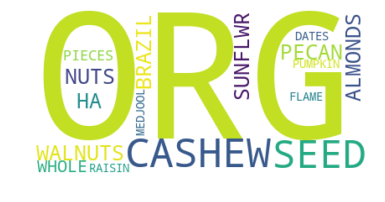

<img src="./img/2018/1554485619.topic2.png">
0.02 Topic #3:
['KALE, GREEN', 'COLLARDS', 'BEETS, RED LOOSE', 'BROCCOLI,  BUNCHED', 'CABBAGE, RED', 'CHARD, RED', 'DANDELION', 'CHARD, RAINBOW', 'CARROTS,  5LB', 'PARSLEY, CURLY']


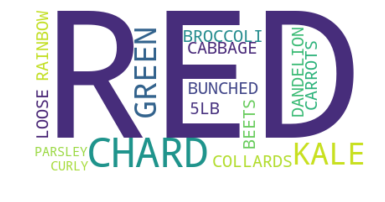

<img src="./img/2018/1554485620.topic3.png">
0.02 Topic #4:
['ARUGULA, LOOSE', 'FENNEL', 'HERBS, BASIL', 'PARMIGIANO REGG', 'BULGARAN FETA', 'RADDICHIO', 'EGGS DZ ROCK LG', 'CUKE MEDIT/PERSIAN', 'FRENCH FETA CHEESE', 'SUGAR PLUM TOM PAK']


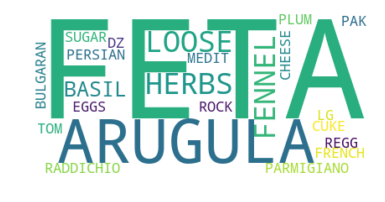

<img src="./img/2018/1554485620.topic4.png">
0.02 Topic #5:
['TOMATOES, ROMA', 'PEPPERS, GREEN BEL', 'EGGPLANT, GLOBE', 'ONIONS, WHITE', 'LETTUCE, ROMAINE', 'PARSLEY, CURLY', 'EGGS DZ ROCK LG', 'PEPPERS, YELLOW BE', 'PEPPERS, ORANGE BE', 'LETTUCE, GREEN LEA']


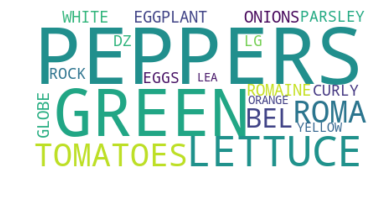

<img src="./img/2018/1554485620.topic5.png">
0.12 Topic #6:
['4110 ORG ROLLED OA', '6645 SUNFLWR SEEDS', '3295  FLAME RAISIN', '3680 BAKERS CH FLO', '2180 BLACK BEANS', '3140 SHRED COCONUT', '4125 OG STL CUT OA', '2195 GARBANZO BEAN', '3065 COCONUT FLAKE', '2215 ORGANIC LENTI']


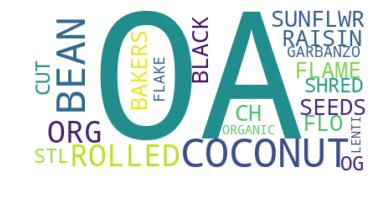

<img src="./img/2018/1554485621.topic6.png">
0.02 Topic #7:
['CAULIFLOWER, BULK', 'BROCCOLI,  BUNCHED', 'CABBAGE, RED', 'BRUSSEL SPROUTS', 'EGGPLANT, GLOBE', 'SQUASH, BUTTERNUT', 'POTATOES, JAPANESE', 'ROOTS, PARSNIP', 'ASPARAGUS', 'FENNEL']


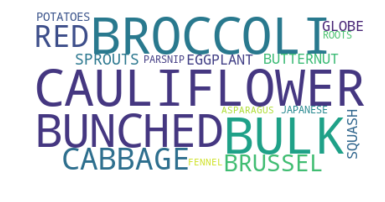

<img src="./img/2018/1554485621.topic7.png">
[['MUSHROOMS, SHIITAK', 'HERBS, BASIL', 'CUKE MEDIT/PERSIAN', 'GRAPES, RED', 'BEETS, RED LOOSE', 'CABBAGE, RED', 'APPLES, GRANNY SMI', 'LETTUCE, ROMAINE', 'BROCCOLI, BABY SWE', 'POTATOES, JAPANESE'], ['8 OZ PLSTC TUB t3', '16OZ PLSTC TUB t4', '2448 CASTEL OLIVE', '2450 KALAMATA-PIT', '2435 BLACK OLIVE', '5495 COCONUT OIL', '24OZ PLSTC TUB t5', '2458 PITD GRN OLIV', '2572 DOLMAS', '2455 OLIVE MEDLEY'], ['5290 WALNUTS', '5120 ORG ALMONDS', '5250 ORG PECAN HA', '5150 BRAZIL NUTS', '6645 SUNFLWR SEEDS', '5180 WHOLE CASHEWS', '5161 CASHEW PIECES', '6560  PUMPKIN SEED', '3295  FLAME RAISIN', '3080 MEDJOOL DATES'], ['KALE, GREEN', 'COLLARDS', 'BEETS, RED LOOSE', 'BROCCOLI,  BUNCHED', 'CABBAGE, RED', 'CHARD, RED', 'DANDELION', 'CHARD, RAINBOW', 'CARROTS,  5LB', 'PARSLEY, CURLY'], ['ARUGULA, LOOSE', 'FENNEL', 'HERBS, BASIL', 'PARMIGIANO REGG', 'BULGARAN FETA', 'RADDICHIO', 'EGGS DZ ROCK LG', 'CUKE MEDIT/PERSIAN', 'FRENCH FETA CHEESE', 'SUGAR PLUM TOM

In [127]:
def print_top_items(model, feature_names, n_top_words):
    topic_dict = defaultdict()
    topics_list =[]
    for topic_idx, topic in enumerate(model.components_):
        print(topic_strength[topic_idx],"Topic #%d:" % topic_idx)
        #topic_string=(" ".join([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]))
        topic_string=[feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict[topic_idx]=topic_string
        topics_list.append(topic_string)
        print(topic_string)
        #print()
        #wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace(" ", "_").replace("'",""))
        wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(str(topic_string).replace("'","").replace(",",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        img_time=str(time.time()).split('.')[0]
        wordcloud.to_file('./img/2018/%s.topic%d.png'%(img_time,topic_idx))
        print('<img src="./img/2018/%s.topic%d.png">'%(img_time,topic_idx))
    return topic_dict,topics_list

topic_dict,topics_list = print_top_items(model,list(items_set),n_top_words)
print(topics_list)

In [128]:
topics3=topic_dict.copy()

In [129]:
topic_compare = np.zeros([len(topic_dict),len(topic_dict)])

for topic in topic_dict:
    for item in topic_dict[topic]:
        for topic2 in topic_dict:
            if item in topic_dict[topic2]:
                topic_compare[topic,topic2]+=1
print (topic_strength)            
print(topic_compare)


[0.68 0.07 0.05 0.02 0.02 0.02 0.12 0.02]
[[10.  0.  0.  2.  2.  1.  0.  2.]
 [ 0. 10.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  2.  0.]
 [ 2.  0.  0. 10.  0.  1.  0.  2.]
 [ 2.  0.  0.  0. 10.  1.  0.  1.]
 [ 1.  0.  0.  1.  1. 10.  0.  1.]
 [ 0.  0.  2.  0.  0.  0. 10.  0.]
 [ 2.  0.  0.  2.  1.  1.  0. 10.]]


In [130]:
list_of_topics=[]
for topic in topic_dict:
     list_of_topics.append(topic_dict[topic])

In [131]:
topic_matrix=np.array(topics_list).T
topic_matrix.shape

(10, 8)

In [132]:
pd.DataFrame(topic_matrix,columns=topic_strength)

,0.68,0.07,0.05,0.02,0.02,0.02,0.12,0.02
0,"MUSHROOMS, SHIITAK",8 OZ PLSTC TUB t3,5290 WALNUTS,"KALE, GREEN","ARUGULA, LOOSE","TOMATOES, ROMA",4110 ORG ROLLED OA,"CAULIFLOWER, BULK"
1,"HERBS, BASIL",16OZ PLSTC TUB t4,5120 ORG ALMONDS,COLLARDS,FENNEL,"PEPPERS, GREEN BEL",6645 SUNFLWR SEEDS,"BROCCOLI, BUNCHED"
2,CUKE MEDIT/PERSIAN,2448 CASTEL OLIVE,5250 ORG PECAN HA,"BEETS, RED LOOSE","HERBS, BASIL","EGGPLANT, GLOBE",3295 FLAME RAISIN,"CABBAGE, RED"
3,"GRAPES, RED",2450 KALAMATA-PIT,5150 BRAZIL NUTS,"BROCCOLI, BUNCHED",PARMIGIANO REGG,"ONIONS, WHITE",3680 BAKERS CH FLO,BRUSSEL SPROUTS
4,"BEETS, RED LOOSE",2435 BLACK OLIVE,6645 SUNFLWR SEEDS,"CABBAGE, RED",BULGARAN FETA,"LETTUCE, ROMAINE",2180 BLACK BEANS,"EGGPLANT, GLOBE"
5,"CABBAGE, RED",5495 COCONUT OIL,5180 WHOLE CASHEWS,"CHARD, RED",RADDICHIO,"PARSLEY, CURLY",3140 SHRED COCONUT,"SQUASH, BUTTERNUT"
6,"APPLES, GRANNY SMI",24OZ PLSTC TUB t5,5161 CASHEW PIECES,DANDELION,EGGS DZ ROCK LG,EGGS DZ ROCK LG,4125 OG STL CUT OA,"POTATOES, JAPANESE"
7,"LETTUCE, ROMAINE",2458 PITD GRN OLIV,6560 PUMPKIN SEED,"CHARD, RAINBOW",CUKE MEDIT/PERSIAN,"PEPPERS, YELLOW BE",2195 GARBANZO BEAN,"ROOTS, PARSNIP"
8,"BROCCOLI, BABY SWE",2572 DOLMAS,3295 FLAME RAISIN,"CARROTS, 5LB",FRENCH FETA CHEESE,"PEPPERS, ORANGE BE",3065 COCONUT FLAKE,ASPARAGUS
9,"POTATOES, JAPANESE",2455 OLIVE MEDLEY,3080 MEDJOOL DATES,"PARSLEY, CURLY",SUGAR PLUM TOM PAK,"LETTUCE, GREEN LEA",2215 ORGANIC LENTI,FENNEL


In [ ]:
ingredients =np.array((len(topics),len(topics[0])))
for row in topics:
    print('row',row)
    for i,item in enumerate(topics[row]):
        if item not in topics[row]:
            print ('i',i,item)
            
        if item not in topics[0]:
            print ('iI',i,item)
        #ingredients[row:i]=item
ingredients

In [ ]:
len(ing_set)

In [ ]:
ing_index_dict = dict(zip(ing_set, range(len(ing_set))))

In [ ]:
ingredients=np.array(ingredients)
ingredients=ingredients.reshape(5,55)

In [ ]:
ingredients.shape

In [ ]:
ing_matrix=np.zeros(ingredients.shape)

In [ ]:
for row,col in enumerate(ingredients):
    for i,c in enumerate(col):
        #print(row,i,c)
        ing_matrix[row,i]=ing_index_dict[c]
ing_matrix

In [ ]:
ing_array=ing_index_dict.values()

ing_array

In [ ]:
for i in ing_matrix:
    print(ing_array==i)

In [ ]:
for ing_index_dict

In [ ]:
def print_basket_contents(basket_id):
    basket=[]
    #print('+++++++++++++++++++++++next basket+++++++++++++++++')
    for items in df['items'][basket_id]:
        #for item in items:
        print("item:",items)
    #return basket
#print_basket_contents(1116)

In [ ]:
def print_top_baskets(model, W, n_top_words):
    baskets = []
    for topic_idx, w in enumerate(W.T):
        basket_string=str([df['items'][i] for i in w.argsort()[:-n_top_words - 1:-1]])
        count = 0
        for i in w.argsort()[:-n_top_words - 1:-1]:
            count+=1
            print("++++++++++++++++++Topic #%d, basket #%d+++++++++++++++++++"%(topic_idx,count))
            print_basket_contents(i)
        #print_basket_contents([i for i in w.argsort()[:-n_top_words - 1:-1]])
        baskets.append(basket_string)
        #print(basket_string)
        #print()
        '''wordcloud = WordCloud(max_font_size=500, max_words=1000, background_color="white").generate(basket_string.replace(" ", "_").replace("'",""))

        # Display the generated image:
        #plt.figure(1,figsize=(10,10))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        #plt.savefig('topic%d.png'%topic_idx)
        #plt.close()
        wordcloud.to_file('topic%d.png'%topic_idx)'''
print_top_baskets(model,W,10)

In [ ]:
df['item_count'].max()

In [ ]:
W[:,1]

In [ ]:
n_top_words=10
for i,w in enumerate(W.T):
    print(i,w.argsort()[:-n_top_words - 1:-1])

In [ ]:
len(list(items_set))

In [ ]:
for topic in H:
    print (topic.argsort()[:-10-1:-1])

In [ ]:
feat
str([feature_names[i]for i in topic.argsort()[:-n_top_words - 1:-1]])

In [ ]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            print (it[1],it[2])

In [ ]:
df.shape[0]
for i in range(10,11):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

In [ ]:
df['CILANTRO'][10:11]

In [ ]:
df.shape[0]
for i in range(1,df.shape[0]):
    row = df['items'][i:i+1]
    for item in row:
        for it in item:
            df[it[1]][i:i+1]=df[it[1]][i:i+1]+it[2]

In [ ]:
df.shape

In [ ]:
df.to_pickle('02012019.pkl')

In [ ]:
len(items_set)

In [ ]:
trans = []
for a in df[1:2]['items']:
    #trans.append([r for v in a for r in v])
    trans.append(a)
print(a)

In [ ]:
trans =[]
for l in [i for i in df[1:2]['items']]:
    print (l)
    trans.append(l)
    print (trans)

In [ ]:
#pd.get_dummies([i for i in df[1:2]['items']]).values()

In [ ]:

type(df['items'].values)
count=0
for document in df['items'][1]:
    print (document)
    
    for word in(document):
        count+=1
        print (count,word)
        '''for letter in str(word):
            print (letter)'''

In [ ]:
df[['gross+','time']].plot()
plt.show()

In [ ]:
ff= './tlogs/201902'
if ff.startswith("./tlogs"):
    print ("yep")

In [ ]:
for f in os.walk('./tlogs'): print ("f:",f,"sub:",sub)


In [ ]:
import os

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file

        if filepath.endswith(".asm"):
            print (filepath)

In [ ]:
df=pd.read_pickle('02012019.pkl')

In [ ]:
df[df['BANANAS']!=0]

In [ ]:
df.columns

In [ ]:
plt.scatter(x=df['time'],y=df['gross+'])

In [ ]:
df.type='Va'

In [ ]:
def get_dataframe(filepath):

    all_files = glob.glob(os.path.join(filepath, "*.json"))
    df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 
    df=df[df['term']<10]
    df['date']=pd.to_datetime(df['date'],yearfirst=True)
    df['day_of_week']=df['date'].dt.day_name()
    df['month']=df['date'].dt.month
    return df

In [ ]:
path = '/Users/Sarah/galvanize/dsi-capstone/jsons/201802/'
df = get_dataframe(path)

In [ ]:
all_files =[]
for f in range(0,366):
    all_files.append(path+"%d.json"%f)
print (all_files)

In [ ]:
import pandas as pd 
df = pd.concat((pd.read_json(f,keep_default_dates=False,lines=True) for f in all_files)) 

In [ ]:
df.info()

In [ ]:
plt.scatter(dfq1['item_count'],dfq1['term'])